# NN e RNN

In [1]:
import pickle
import json
from typing import Dict

import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras


## Preparação dos dados

### Carregar

In [2]:
dataset_folder = "..\\data"

In [3]:
file = open(dataset_folder+"\\train_df", 'rb')
train_df = pickle.load(file)
file.close()

file = open(dataset_folder+"\\val_df", 'rb')
val_df = pickle.load(file)
file.close()

file = open(dataset_folder+"\\info.json", 'r')
info_dict = json.load(file)
file.close()

In [4]:
features_names = info_dict["feature_names"]

features_names

['Nome_municipio',
 'Dia',
 'Precipitacao',
 'Pressao_at_max',
 'Pressao_at_min',
 'Radiacao',
 'Temp_max',
 'Temp_min',
 'Umidade',
 'Max_vent',
 'Velocidade_vent',
 'Pop_estimada']

### Verificação

Verifica se existe algum problema com os dados.

In [5]:
train_df.isna().sum()

Nome_municipio     0
Dia                0
Precipitacao       0
Pressao_at_max     0
Pressao_at_min     0
Radiacao           0
Temp_max           0
Temp_min           0
Umidade            0
Max_vent           0
Velocidade_vent    0
Pop_estimada       0
Casos              0
Casos_pela_pop     0
dtype: int64

In [6]:
val_df.isna().sum()

Nome_municipio     0
Dia                0
Precipitacao       0
Pressao_at_max     0
Pressao_at_min     0
Radiacao           0
Temp_max           0
Temp_min           0
Umidade            0
Max_vent           0
Velocidade_vent    0
Pop_estimada       0
Casos              0
Casos_pela_pop     0
dtype: int64

### Separação

In [7]:
train_features = train_df[features_names]
val_features = val_df[features_names]

drop_columns = ["Nome_municipio", "Dia"]

for column in drop_columns:
    train_features.drop(column, axis="columns", inplace=True)
    val_features.drop(column, axis="columns", inplace=True)

train_target = train_df["Casos_pela_pop"]
val_target = val_df["Casos_pela_pop"]

C:\Python38\lib\site-packages\pandas\core\frame.py:4167: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [8]:
n_features = train_features.shape[1]
n_target = 1

### Normalização

In [9]:
description = train_features.describe()

In [10]:
train_dist = {}

for column in train_features.columns:
    train_dist[column] = {}
    train_dist[column]["mean"] = description[column]["mean"]
    train_dist[column]["std"] = description[column]["std"]

In [11]:
file = open("train_dist.json", "w")
json.dump(train_dist, file)
file.close()

In [12]:
for df in [train_features, val_features]:
    for column in train_features:
        df.loc[:, column] = (df[column]-train_dist[column]["mean"])/train_dist[column]["std"]

C:\Python38\lib\site-packages\pandas\core\indexing.py:1781: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item_labels[indexer[info_axis]]] = value


In [13]:
train_features.describe()

,Precipitacao,Pressao_at_max,Pressao_at_min,Radiacao,Temp_max,Temp_min,Umidade,Max_vent,Velocidade_vent,Pop_estimada
count,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06
mean,-2.245522e-16,-1.432445e-15,2.329507e-14,-1.473959e-15,-1.436714e-15,1.905683e-15,5.725955e-16,-1.154622e-16,-9.053457e-16,-1.784184e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.060475e-01,-3.754402e+00,-3.763698e+00,-2.740855e+00,-5.989725e+00,-6.060539e+00,-3.623111e+00,-2.937551e+00,-1.826297e+00,-3.112124e-01
25%,-3.060475e-01,-7.682675e-01,-7.684687e-01,-6.173573e-01,-5.796011e-01,-5.648660e-01,-6.524339e-01,-6.598478e-01,-6.869443e-01,-2.882414e-01
50%,-3.060475e-01,2.465197e-02,2.413291e-02,1.036241e-01,1.490688e-01,1.825455e-01,6.375657e-02,-7.367400e-02,-1.347116e-01,-2.394346e-01
75%,-2.515670e-01,9.055588e-01,9.042712e-01,7.030119e-01,6.980666e-01,7.321128e-01,7.206848e-01,5.459954e-01,5.740864e-01,-1.117164e-01
max,2.892274e+01,2.317003e+00,2.323264e+00,7.149043e+00,3.233438e+00,4.557101e+00,2.277895e+00,2.342352e+01,1.335032e+01,1.216895e+01


In [14]:
target_dist = {}
target_dist["mean"] = train_target.mean()
target_dist["std"] = train_target.std()

In [15]:
file = open("target_dist.json", "w")
json.dump(target_dist, file)
file.close()

In [16]:
for df in [train_target, val_target]:
    df = (df-target_dist["mean"])/target_dist["std"]

## Infraestrutura para treino

In [17]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: eltoncn (use `wandb login --relogin` to force relogin)


True

In [18]:
BATCH_SIZE = 84959
STEPS_PER_EPOCH = int(len(train_features)/BATCH_SIZE)
STEPS_PER_EPOCH

21

In [53]:
class ModelManager:

    def __init__(self, project_name, train_features, train_target, val_features, val_target, save_dir="."):
        self._project_name = project_name

        self._save_dir = save_dir
        self._model_save_dir = self._save_dir+"\\models"
        self._log_dir = self._save_dir+"\\log"
        
        self._models :Dict[str, keras.Model] = {}
        self._current_model = ""

        self._architectures = {}
        self._hist = {}

        self._data = {}
        self._data["train_features"] = np.asarray(train_features)
        self._data["train_target"] = np.asarray(train_target)
        self._data["val_features"] = np.asarray(val_features)
        self._data["val_target"] = np.asarray(val_target)

    def register_model(self, model, model_name, architecture_name):
        self._current_model = model_name

        self._models[model_name] = model
        self._architectures[model_name] = architecture_name

    def compile_fit_save(self, epochs, optimizer, model_name=None, batch_size=BATCH_SIZE, patience=None, verbose='auto', loss="mean_squared_error"):
        if model_name is None:
            model_name = self._current_model
        else:
            self._current_model = model_name

        learning_rate = optimizer.learning_rate.numpy()
        
        config = {}
        config["leaning_rate"] = learning_rate
        config["epochs"] = epochs
        config["architecture"] = self._architectures[model_name]
        config["batch_size"] = batch_size
        config["optimizer"] = optimizer._name
        config["loss"] = loss
        config["patience"] = patience

        run = wandb.init(project=self._project_name, entity="breath",
                           config = config)

        metrics = [tf.keras.losses.mean_absolute_error, tf.keras.losses.mean_squared_error]

        model = self._models[model_name]
        model.compile(optimizer=optimizer, 
                        loss= tf.keras.losses.get(loss),
                        metrics=metrics)
        
        callbacks = []
        callbacks.append(WandbCallback("val_mean_squared_error" ))
        #callbacks.append(keras.callbacks.TensorBoard(log_dir=self._log_dir, histogram_freq=1))
        
        if patience is not None:
            callbacks.append(keras.callbacks.EarlyStopping(monitor="val_mean_squared_error", patience=patience))

        self._hist[model_name] = model.fit(x=self._data["train_features"], y=self._data["train_target"], 
                                    validation_data=(self._data["val_features"], self._data["val_target"]),
                                    epochs=epochs, batch_size=batch_size,
                                    callbacks= callbacks, verbose=verbose)

        predictions = model.predict(train_features.to_numpy()[:10000]).flatten()
        plt.plot(train_df["Dia"][:10000], train_target.to_numpy()[:10000])
        plt.plot(train_df["Dia"][:10000], predictions)
        plt.ylim(-0.00001, 0.0001)
        plt.ylabel("Casos/População")
        plt.legend(["GT", "Predito"])

        wandb.log({"predictions":plt})
        plt.show()

        wandb.finish()

    def save(self, model_name):
        self._models[model_name].save(self._model_save_dir)

        try:
            keras.models.load_model(self._model_save_dir)
        except Exception as e:
            print(e)
            print("ERRO AO SALVAR O MODELO")
    
    def load(self, model_name):
        self._models[model_name] = keras.models.load_model(self._model_save_dir)

        self._current_model = model_name

In [54]:
manager = ModelManager("BReATH", train_features.to_numpy(), train_target.to_numpy(), val_features.to_numpy(), val_target.to_numpy(), save_dir=".\\save")

In [21]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_device[0],True)


In [22]:
# Lança exceção (útil para executar todo o notebook até este ponto após falha do tf enquanto treinava algum modelo)

raise Exception()

Exception: 

## Modelos NN

In [55]:
def create_first():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(100, activation="relu")(input)
    x = keras.layers.Dense(100, activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
first_model = create_first()

manager.register_model(first_model, "first", "first")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200)

Epoch 1/200
21/21 [==============================] - 1s 17ms/step - loss: 0.0011 - mean_absolute_error: 0.0059 - mean_squared_error: 0.0011 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 2/200
21/21 [==============================] - 0s 11ms/step - loss: 3.2899e-11 - mean_absolute_error: 2.1021e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 3/200
21/21 [==============================] - 0s 11ms/step - loss: 3.2899e-11 - mean_absolute_error: 2.1021e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 4/200
21/21 [==============================] - 0s 11ms/step - loss: 3.2899e-11 - mean_absolute_error: 2.1021e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 5/200


C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,▅▅███▅█▁█▅▅▅▅█▅█▅████▅██▅█▅█▅██▅▅███▅█▅█
mean_absolute_error,▇▅▅▇▅█▇▅▄▄▅▄▄▅▁▇▄▁▁▄▄▅▄▄▅▄▅▅▅▅▅▄▄█▄▅▅▅▅▁
mean_squared_error,▅▅███▅█▁▅▅▅▅▅███▅▅███▅██▅█▅████▅▅███▅█▅█
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,0
best_val_mean_squared_error,0.0
epoch,199
loss,0.0


In [ ]:
def create_larger():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="relu")(input)
    x = keras.layers.Dense(1000, activation="relu")(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

In [ ]:
larger_model = create_larger()
manager.register_model(larger_model, "larger", "larger")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200)

In [ ]:
def create_small():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(100, activation="relu")(input)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

small_model = create_small()
manager.register_model(small_model, "small", "small")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200)

Epoch 1/200
21/21 [==============================] - 1s 14ms/step - loss: 0.0288 - mean_absolute_error: 0.0824 - mean_squared_error: 0.0288 - val_loss: 1.8916e-04 - val_mean_absolute_error: 0.0021 - val_mean_squared_error: 1.8916e-04
Epoch 2/200
21/21 [==============================] - 0s 8ms/step - loss: 5.9924e-05 - mean_absolute_error: 6.3904e-04 - mean_squared_error: 5.9924e-05 - val_loss: 2.0317e-05 - val_mean_absolute_error: 2.5047e-04 - val_mean_squared_error: 2.0317e-05
Epoch 3/200
21/21 [==============================] - 0s 8ms/step - loss: 1.4442e-05 - mean_absolute_error: 1.6525e-04 - mean_squared_error: 1.4442e-05 - val_loss: 1.1313e-05 - val_mean_absolute_error: 1.5360e-04 - val_mean_squared_error: 1.1313e-05
Epoch 4/200
21/21 [==============================] - 0s 9ms/step - loss: 9.2642e-06 - mean_absolute_error: 1.1469e-04 - mean_squared_error: 9.2642e-06 - val_loss: 8.3571e-06 - val_mean_absolute_error: 1.2057e-04 - val_mean_squared_error: 8.3571e-06
Epoch 5/200
21/21 [

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,199
best_val_mean_squared_error,0.0
epoch,199
loss,0.0


### RNN

In [ ]:
def create_first_lstm():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32)(input)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_first_lstm()
manager.register_model(model, "first_lstm", "first_lstm")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

Epoch 1/100
21/21 [==============================] - 5s 76ms/step - loss: 6.7360e-05 - mean_absolute_error: 0.0013 - mean_squared_error: 6.7360e-05 - val_loss: 1.3603e-05 - val_mean_absolute_error: 2.0490e-04 - val_mean_squared_error: 1.3603e-05
Epoch 2/100
21/21 [==============================] - 1s 47ms/step - loss: 1.5377e-09 - mean_absolute_error: 4.5421e-07 - mean_squared_error: 1.5377e-09 - val_loss: 2.5996e-07 - val_mean_absolute_error: 1.0307e-05 - val_mean_squared_error: 2.5996e-07
Epoch 3/100
21/21 [==============================] - 1s 46ms/step - loss: 5.4599e-10 - mean_absolute_error: 3.0575e-07 - mean_squared_error: 5.4599e-10 - val_loss: 9.6334e-08 - val_mean_absolute_error: 4.8276e-06 - val_mean_squared_error: 9.6334e-08
Epoch 4/100
21/21 [==============================] - 1s 45ms/step - loss: 4.7677e-10 - mean_absolute_error: 2.9345e-07 - mean_squared_error: 4.7677e-10 - val_loss: 8.3151e-08 - val_mean_absolute_error: 4.2970e-06 - val_mean_squared_error: 8.3151e-08
Epoc

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,99
best_val_mean_squared_error,0.0
epoch,99
loss,0.0


In [ ]:
def create_lstm2():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32, return_sequences=True)(input)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_lstm2()
manager.register_model(model, "lstm2", "lstm2")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,99
best_val_mean_squared_error,0.0
epoch,99
loss,0.0


Epoch 1/100
21/21 [==============================] - 7s 135ms/step - loss: 7.4729e-07 - mean_absolute_error: 1.0748e-04 - mean_squared_error: 7.4729e-07 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 2/100
21/21 [==============================] - 2s 97ms/step - loss: 3.2899e-11 - mean_absolute_error: 2.1021e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 3/100
21/21 [==============================] - 2s 98ms/step - loss: 3.2899e-11 - mean_absolute_error: 2.1021e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 4/100
21/21 [==============================] - 2s 97ms/step - loss: 3.2899e-11 - mean_absolute_error: 2.1021e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11

ValueError: x and y must have same first dimension, but have shapes (10000,) and (100000,)

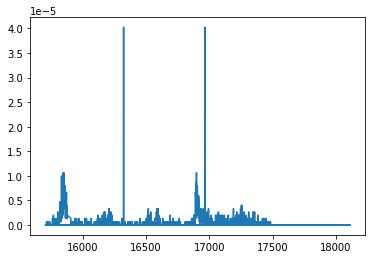

In [ ]:
def create_lstm3():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32)(input)
    x = keras.layers.LSTM(32)(x)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_lstm3()
manager.register_model(model, "lstm3", "lstm3")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,0
best_val_mean_squared_error,0.0
epoch,99
loss,0.0


Epoch 1/100
21/21 [==============================] - 8s 27ms/step - loss: 0.0065 - mean_absolute_error: 0.0296 - mean_squared_error: 0.0065 - val_loss: 3.9914e-05 - val_mean_absolute_error: 6.6328e-04 - val_mean_squared_error: 3.9914e-05
Epoch 2/100
21/21 [==============================] - 0s 13ms/step - loss: 3.5450e-05 - mean_absolute_error: 6.0868e-04 - mean_squared_error: 3.5450e-05 - val_loss: 2.2817e-05 - val_mean_absolute_error: 4.6934e-04 - val_mean_squared_error: 2.2817e-05
Epoch 3/100
21/21 [==============================] - 0s 13ms/step - loss: 1.3272e-05 - mean_absolute_error: 2.8930e-04 - mean_squared_error: 1.3272e-05 - val_loss: 3.3398e-06 - val_mean_absolute_error: 9.3312e-05 - val_mean_squared_error: 3.3398e-06
Epoch 4/100
21/21 [==============================] - 0s 13ms/step - loss: 2.1375e-06 - mean_absolute_error: 6.3795e-05 - mean_squared_error: 2.1375e-06 - val_loss: 7.9975e-07 - val_mean_absolute_error: 2.6837e-05 - val_mean_squared_error: 7.9975e-07
Epoch 5/100


ValueError: x and y must have same first dimension, but have shapes (10000,) and (80000,)

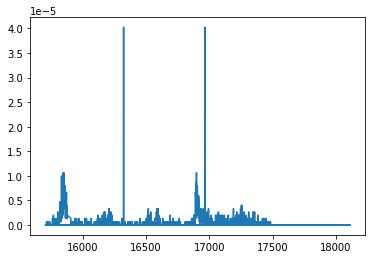

In [ ]:
def create_cnn():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.Conv1D(32, kernel_size=(3, ))(input)

    out = keras.layers.Dense(1, activation="relu")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_cnn()
manager.register_model(model, "cnn1", "cnn1")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

In [ ]:
model = create_first()
manager.register_model(model, "first_sgd", "first")
manager.compile_fit_save(optimizer=keras.optimizers.SGD(learning_rate=0.0005), epochs=100)

epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,99
best_val_mean_squared_error,0.0
epoch,99
loss,0.0


Epoch 1/100
21/21 [==============================] - 1s 19ms/step - loss: 0.0040 - mean_absolute_error: 0.0253 - mean_squared_error: 0.0040 - val_loss: 0.0036 - val_mean_absolute_error: 0.0246 - val_mean_squared_error: 0.0036
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0037 - mean_absolute_error: 0.0242 - mean_squared_error: 0.0037 - val_loss: 0.0034 - val_mean_absolute_error: 0.0235 - val_mean_squared_error: 0.0034
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 0.0035 - mean_absolute_error: 0.0232 - mean_squared_error: 0.0035 - val_loss: 0.0032 - val_mean_absolute_error: 0.0225 - val_mean_squared_error: 0.0032
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - loss: 0.0033 - mean_absolute_error: 0.0223 - mean_squared_error: 0.0033 - val_loss: 0.0030 - val_mean_absolute_error: 0.0216 - val_mean_squared_error: 0.0030
Epoch 5/100
21/21 [==============================] - 0s 10ms/step - loss: 0.0031 - mean_absolute

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▇▇▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▇▆▅▅▄▄▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▇▆▅▅▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,99
best_val_mean_squared_error,0.0002
epoch,99
loss,0.00028


In [ ]:
def create_first_sigmoid():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(100, activation="sigmoid")(input)
    x = keras.layers.Dense(100, activation="sigmoid")(x)

    out = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_first_sigmoid()
manager.register_model(model, "first_sigmoid", "first_sigmoid")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100)

Epoch 1/100
21/21 [==============================] - 1s 18ms/step - loss: 0.0187 - mean_absolute_error: 0.1102 - mean_squared_error: 0.0187 - val_loss: 0.0010 - val_mean_absolute_error: 0.0318 - val_mean_squared_error: 0.0010
Epoch 2/100
21/21 [==============================] - 0s 11ms/step - loss: 5.5673e-04 - mean_absolute_error: 0.0233 - mean_squared_error: 5.5673e-04 - val_loss: 3.4048e-04 - val_mean_absolute_error: 0.0184 - val_mean_squared_error: 3.4048e-04
Epoch 3/100
21/21 [==============================] - 0s 12ms/step - loss: 2.8962e-04 - mean_absolute_error: 0.0170 - mean_squared_error: 2.8962e-04 - val_loss: 2.5192e-04 - val_mean_absolute_error: 0.0159 - val_mean_squared_error: 2.5192e-04
Epoch 4/100
21/21 [==============================] - 0s 11ms/step - loss: 2.3151e-04 - mean_absolute_error: 0.0152 - mean_squared_error: 2.3151e-04 - val_loss: 2.1211e-04 - val_mean_absolute_error: 0.0146 - val_mean_squared_error: 2.1211e-04
Epoch 5/100
21/21 [=============================

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▄▄▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,99
best_val_mean_squared_error,0.0
epoch,99
loss,0.0


In [23]:
def create_larger_sigmoid():
    input = keras.Input(shape=(n_features), name="input")
    
    x = keras.layers.Dense(1000, activation="sigmoid")(input)
    x = keras.layers.Dense(1000, activation="sigmoid")(x)

    out = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_larger_sigmoid()
manager.register_model(model, "larger_sigmoid", "larger_sigmoid")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20)

Epoch 1/100
21/21 [==============================] - 4s 145ms/step - loss: 0.0029 - mean_absolute_error: 0.0119 - mean_squared_error: 0.0029 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7905e-07 - val_mean_squared_error: 1.5895e-11
Epoch 2/100
21/21 [==============================] - 3s 140ms/step - loss: 3.2899e-11 - mean_absolute_error: 2.1074e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7851e-07 - val_mean_squared_error: 1.5895e-11
Epoch 3/100
21/21 [==============================] - 3s 137ms/step - loss: 3.2899e-11 - mean_absolute_error: 2.1055e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7847e-07 - val_mean_squared_error: 1.5895e-11
Epoch 4/100
21/21 [==============================] - 3s 140ms/step - loss: 3.2899e-11 - mean_absolute_error: 2.1053e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5895e-11 - val_mean_absolute_error: 1.7846e-07 - val_mean_squared_error: 1.5895e-11
Epoch 5/

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▇███████████████████
val_mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▇███████████████████
best_epoch,0
best_val_mean_squared_error,0.0
epoch,20
loss,0.0


In [24]:
def create_lstm_sigmoid():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32)(input)

    out = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_lstm_sigmoid()
manager.register_model(model, "lstm_sigmoid", "lstm_sigmoid")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20)

Epoch 1/100
21/21 [==============================] - 4s 63ms/step - loss: 0.2191 - mean_absolute_error: 0.4674 - mean_squared_error: 0.2191 - val_loss: 0.1739 - val_mean_absolute_error: 0.4165 - val_mean_squared_error: 0.1739
Epoch 2/100
21/21 [==============================] - 1s 48ms/step - loss: 0.1013 - mean_absolute_error: 0.3060 - mean_squared_error: 0.1013 - val_loss: 0.0178 - val_mean_absolute_error: 0.1310 - val_mean_squared_error: 0.0178
Epoch 3/100
21/21 [==============================] - 1s 49ms/step - loss: 0.0034 - mean_absolute_error: 0.0439 - mean_squared_error: 0.0034 - val_loss: 1.2134e-04 - val_mean_absolute_error: 0.0097 - val_mean_squared_error: 1.2134e-04
Epoch 4/100
21/21 [==============================] - 1s 44ms/step - loss: 4.8482e-05 - mean_absolute_error: 0.0066 - mean_squared_error: 4.8482e-05 - val_loss: 4.3208e-05 - val_mean_absolute_error: 0.0054 - val_mean_squared_error: 4.3208e-05
Epoch 5/100
21/21 [==============================] - 1s 43ms/step - loss

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,99
best_val_mean_squared_error,0.0
epoch,99
loss,0.0


In [26]:
def create_lstm_sigmoid2():
    input = keras.Input(shape=(n_features,1), name="input")
    
    x = keras.layers.LSTM(32, return_sequences=True)(input)
    x = keras.layers.LSTM(32)(x)

    out = keras.layers.Dense(1, activation="sigmoid")(x)

    model = keras.Model(inputs=[input], outputs=[out])

    return model

model = create_lstm_sigmoid2()
manager.register_model(model, "lstm_sigmoid2", "lstm_sigmoid2")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20)

Epoch 1/100
21/21 [==============================] - 5s 119ms/step - loss: 0.2094 - mean_absolute_error: 0.4560 - mean_squared_error: 0.2094 - val_loss: 0.1326 - val_mean_absolute_error: 0.3630 - val_mean_squared_error: 0.1326
Epoch 2/100
21/21 [==============================] - 2s 93ms/step - loss: 0.0385 - mean_absolute_error: 0.1582 - mean_squared_error: 0.0385 - val_loss: 5.0613e-04 - val_mean_absolute_error: 0.0223 - val_mean_squared_error: 5.0613e-04
Epoch 3/100
21/21 [==============================] - 2s 93ms/step - loss: 1.7247e-04 - mean_absolute_error: 0.0125 - mean_squared_error: 1.7247e-04 - val_loss: 7.2303e-05 - val_mean_absolute_error: 0.0085 - val_mean_squared_error: 7.2303e-05
Epoch 4/100
21/21 [==============================] - 2s 92ms/step - loss: 5.9345e-05 - mean_absolute_error: 0.0077 - mean_squared_error: 5.9345e-05 - val_loss: 5.2316e-05 - val_mean_absolute_error: 0.0072 - val_mean_squared_error: 5.2316e-05
Epoch 5/100
21/21 [==============================] - 2s

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,99
best_val_mean_squared_error,0.0
epoch,99
loss,0.0


In [31]:
model = create_first()
manager.register_model(model, "first_log", "first")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20, loss="mean_squared_logarithmic_error")

Epoch 1/100
21/21 [==============================] - 1s 19ms/step - loss: 0.0044 - mean_absolute_error: 0.0222 - mean_squared_error: 0.0060 - val_loss: 1.5855e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 2/100
21/21 [==============================] - 0s 12ms/step - loss: 3.2841e-11 - mean_absolute_error: 2.1021e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5855e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 3/100
21/21 [==============================] - 0s 13ms/step - loss: 3.2841e-11 - mean_absolute_error: 2.1021e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5855e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 4/100
21/21 [==============================] - 0s 12ms/step - loss: 3.2841e-11 - mean_absolute_error: 2.1021e-07 - mean_squared_error: 3.2899e-11 - val_loss: 1.5855e-11 - val_mean_absolute_error: 1.7815e-07 - val_mean_squared_error: 1.5895e-11
Epoch 5/100


C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
loss,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,0
best_val_mean_squared_error,0.0
epoch,20
loss,0.0


In [46]:
train_features_zeroless = train_features.to_numpy()
train_target_zeroless = train_target.to_numpy()
val_features_zeroless = val_features.to_numpy()
val_target_zeroless = val_target.to_numpy()

mask = train_target_zeroless != 0
val_mask = val_target_zeroless != 0

train_target_zeroless = train_target_zeroless[mask]
train_features_zeroless = train_features_zeroless[mask]
val_features_zeroless = val_features_zeroless[val_mask]
val_target_zeroless = val_target_zeroless[val_mask]

In [47]:
train_features.describe()

,Precipitacao,Pressao_at_max,Pressao_at_min,Radiacao,Temp_max,Temp_min,Umidade,Max_vent,Velocidade_vent,Pop_estimada
count,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06,1.784139e+06
mean,-2.245522e-16,-1.432445e-15,2.329507e-14,-1.473959e-15,-1.436714e-15,1.905683e-15,5.725955e-16,-1.154622e-16,-9.053457e-16,-1.784184e-18
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-3.060475e-01,-3.754402e+00,-3.763698e+00,-2.740855e+00,-5.989725e+00,-6.060539e+00,-3.623111e+00,-2.937551e+00,-1.826297e+00,-3.112124e-01
25%,-3.060475e-01,-7.682675e-01,-7.684687e-01,-6.173573e-01,-5.796011e-01,-5.648660e-01,-6.524339e-01,-6.598478e-01,-6.869443e-01,-2.882414e-01
50%,-3.060475e-01,2.465197e-02,2.413291e-02,1.036241e-01,1.490688e-01,1.825455e-01,6.375657e-02,-7.367400e-02,-1.347116e-01,-2.394346e-01
75%,-2.515670e-01,9.055588e-01,9.042712e-01,7.030119e-01,6.980666e-01,7.321128e-01,7.206848e-01,5.459954e-01,5.740864e-01,-1.117164e-01
max,2.892274e+01,2.317003e+00,2.323264e+00,7.149043e+00,3.233438e+00,4.557101e+00,2.277895e+00,2.342352e+01,1.335032e+01,1.216895e+01


In [49]:
manager._data["train_features"] = train_features_zeroless
manager._data["train_target"] = train_target_zeroless
manager._data["val_features"] = val_features_zeroless
manager._data["val_target"] = val_target_zeroless

In [52]:
train_features_zeroless.shape

(28849, 10)

In [50]:
model = create_first()
manager.register_model(model, "first_zeroless", "first_zeroless")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=100, patience=20)

Epoch 1/100
1/1 [==============================] - 1s 582ms/step - loss: 0.0664 - mean_absolute_error: 0.0754 - mean_squared_error: 0.0664 - val_loss: 0.0215 - val_mean_absolute_error: 0.0266 - val_mean_squared_error: 0.0215
Epoch 2/100
1/1 [==============================] - 0s 22ms/step - loss: 0.0359 - mean_absolute_error: 0.0431 - mean_squared_error: 0.0359 - val_loss: 0.0104 - val_mean_absolute_error: 0.0145 - val_mean_squared_error: 0.0104
Epoch 3/100
1/1 [==============================] - 0s 24ms/step - loss: 0.0190 - mean_absolute_error: 0.0255 - mean_squared_error: 0.0190 - val_loss: 0.0046 - val_mean_absolute_error: 0.0076 - val_mean_squared_error: 0.0046
Epoch 4/100
1/1 [==============================] - 0s 23ms/step - loss: 0.0094 - mean_absolute_error: 0.0151 - mean_squared_error: 0.0094 - val_loss: 0.0018 - val_mean_absolute_error: 0.0039 - val_mean_squared_error: 0.0018
Epoch 5/100
1/1 [==============================] - 0s 25ms/step - loss: 0.0041 - mean_absolute_error: 0

C:\Python38\lib\site-packages\plotly\matplotlylib\renderer.py:612: UserWarning:

I found a path object that I don't think is part of a bar chart. Ignoring.



epoch,▁▁▁▂▂▂▃▃▃▃▃▄▄▄▅▅▅▅▅▆▆▆▇▇▇▇▇██
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_absolute_error,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
mean_squared_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_absolute_error,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_mean_squared_error,█▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
best_epoch,8
best_val_mean_squared_error,0.0
epoch,28
loss,0.0


In [ ]:
first_model = create_first()

manager.register_model(first_model, "first", "first")
manager.compile_fit_save(optimizer=keras.optimizers.Adam(), epochs=200)